In [1]:
import pandas as pd 
import numpy as np
import time
import re
from sklearn.feature_extraction.text import CountVectorizer
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import learning_curve
from sklearn.metrics import classification_report, roc_auc_score, matthews_corrcoef
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.svm import LinearSVC,SVR
from sklearn.feature_selection import RFECV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import Binarizer
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

In [2]:
# java_stop_words = stopwords.words('english')
stop_words = ['_x000d_', 'new', 'test','public','void','country', 'class', 'def','cn', 'com', 'xd', 'yoda', 'this', 'not','xd', 'yoda']
# java_stop_words.extend(custom_words)

def clean_words(text):
    res = re.findall(r'\b\w+\b', text)
    return res

def remove_stopwords(text):
    text = str(text).lower().strip()
    tokens = []
    for token in text:
        if token not in stop_words:
            tokens.append(token)
            
    return "".join(tokens)


In [3]:
def remove_comments(text):
    no_comments = re.sub(r'#.*', '', text)
    no_comments = re.sub(r'/\*.*\/\*', '', no_comments)
    no_comments = re.sub(r'\d+','',no_comments)
    no_comments = re.sub(r'_', ' ', no_comments)
    return no_comments

def remove_cammel(text):
    no_cammel = re.sub('([A-Z][a-z]+)', r' \1', re.sub('([A-Z]+)', r' \1', text)).lower().split()
    return no_cammel

In [4]:
# def init_dataset(filename, language):
#     data = pd.read_excel(filename)
#     df = pd.DataFrame(data, columns=['Language', 'project name', 'test case name', 'label','test case content', 'tokens'])
    

In [5]:
#init dataset
data = pd.read_excel('./flaky_data.xlsx')
df = pd.DataFrame(data, columns=['Language', 'project name', 'test case name', 'label','test case content', 'tokens'])
df.drop('project name', axis=1, inplace=True)
df.drop('test case name', axis=1, inplace=True)


#remove comments

df['test case content'] = df['test case content'].apply(lambda x: remove_comments(x))
df['test case content'] = df['test case content'].apply(lambda x: remove_cammel(x))
# df['test case content'] = df['test case content'].apply(lambda x: clean_words(x))


df['tokens'] = df['test case content']



In [6]:
#filter python data and tokenize
js_df = df[df['Language'] == 'JS']
java_df = df[df['Language'] == 'Java']
combined_df = pd.concat([java_df, js_df], axis=0)
java_js_df = combined_df.reset_index(drop=True)

tokenizer = CountVectorizer(analyzer='word', max_features=1500,stop_words=stop_words)

    
java_js_df.tokens = java_js_df.tokens.apply(lambda x: remove_stopwords(x))
bow_token = tokenizer.fit_transform(java_js_df.tokens)

bow_data = pd.DataFrame(bow_token.toarray(), columns=tokenizer.get_feature_names_out())

#save the vocabulary to extract features on "production"

pickle.dump(tokenizer.vocabulary_, open("./vocabulary/python.dict", 'wb'))


In [7]:
print(list(tokenizer.vocabulary_))

['insert', 'sql', 'session', 'mybatis', 'helper', 'get', 'try', 'user', 'info', 'able', 'mapper', 'set', 'username', 'password', 'email', 'false', 'assert', 'equals', 'null', 'id', 'int', 'select', 'by', 'primary', 'key', 'finally', 'rollback', 'close', 'dynamic', 'countrycode', 'countryname', 'list', 'size', 'delete', 'selective', 'hh', 'all', 'table', 'name', 'page', 'us', 'columns', 'china', 'true', 'found', 'properties', 'map', 'hash', 'put', 'result', 'one', 'update', 'and', 'version', 'integer', 'example', 'create', 'criteria', 'greater', 'than', 'count', '查询总数', 'like', 'or', 'distinct', 'builder', 'build', 'countries', 'for', 'where', 'sqls', 'custom', 'order', 'equal', 'to', 'value', 'of', 'between', 'in', 'array', 'arrays', 'as', 'less', 'is', 'multi', 'desc', 'system', 'out', 'println', 'condition', 'length', 'add', 'object', 'string', 'exception', 'expect', 'message', 'check', 'correct', 'property', '天朝', 'throws', 'run', 'refresh', 'cache', 'without', 'convertor', 'abstrac

In [8]:
java_js_df.drop('tokens', axis=1, inplace=True)
java_js_df.drop('test case content', axis=1, inplace=True)
java_js_df.drop('Language', axis=1, inplace=True)
java_js_df.reset_index()
# java_df.dropna(inplace=True)



,index,label
0,0,Flaky
1,1,Flaky
2,2,Flaky
3,3,Flaky
4,4,Flaky
...,...,...
1960,1960,NonFlaky
1961,1961,NonFlaky
1962,1962,NonFlaky
1963,1963,NonFlaky


In [9]:

y = java_js_df.label.copy()
java_js_df = pd.concat([java_js_df, bow_data], axis=1)


In [10]:
java_js_df = java_js_df.drop('label', axis=1)
x = java_js_df

In [11]:
# split train test data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=1)


In [12]:
#init classifiers

classifiers = {
    'randomForest': RandomForestClassifier(random_state=1),
    'decisionTree': DecisionTreeClassifier(min_samples_leaf=1),
    'naiveBayes': GaussianNB(),
    'smo': CalibratedClassifierCV(LinearSVC(fit_intercept=False, tol=0.001, C=1, dual=False, max_iter=100000), method='sigmoid'),
    'knn': KNeighborsClassifier(n_neighbors=1, metric='euclidean'),
    'logisticRegression': LogisticRegression(max_iter=1000),
    'perceptron': CalibratedClassifierCV(Perceptron()),
    'lda': LinearDiscriminantAnalysis(),
}

In [13]:
def save_incorrect_classifications(x_test, predicted, label, classifier):
    label = label.to_frame(name='labeltestclass').reset_index()
    predicted = pd.DataFrame(predicted, columns=['predictedclass']).reset_index()
    
    df = pd.DataFrame(x_test).reset_index()
    df['labeltestclass'] = label.reset_index()['labeltestclass']
    df['predictedclass'] = predicted.reset_index()['predictedclass']
    
    df[df.predictedclass != df.labeltestclass].to_csv("./IC/"+classifier+"_IC.txt")


def round_float(value):
    return float("{:.3f}".format(value))


def get_time(start_time):
    end_time = time.time()
    return end_time - start_time


def plot_learning_curve(estimator, name, title, x,y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    
    if axes is None:
        fig, axes = plt.subplots(1, 3, figsize=(30, 7))
        
    axes[0].set_title(title)
    
    if ylim is not None:
        axes[0].set_ylim(*ylim)
        
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")
    
    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, x, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.mean(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)
    
    # plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1, color='r')
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1, color='g')
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color='r', label='training score')
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    axes[0].legend(loc="best")
    
    # plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std, fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")
    
    #plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")
    
    fig.savefig('./plot' + name + '.png')            
    

In [14]:
def plot_comparison(comparison_values):
    
    comp = plt.figure(figsize=(10, 10))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))

    for key, classifier in comparison_values.items():
        fraction_of_positives, mean_predicted_value = calibration_curve(classifier['y_test'], classifier['y_probs'], n_bins=10)
        ax1.plot(mean_predicted_value, fraction_of_positives, "s-",label="%s" % (key))
        ax2.hist(classifier['y_probs'], range=(0, 1), bins=10, label=key, histtype="step", lw=2)

    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title('Calibration plots  (reliability curve)')        

    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")
    ax2.legend(loc="upper center", ncol=2)

    comp.tight_layout()
    
    comp.savefig('./plot/compare.png')

In [15]:
def classify(x_train, x_test, y_train, y_test, classifiers, normalize=[], plot=True):
    
    labels = ['Flaky', 'NonFlaky']
    results = pd.DataFrame()
    
    comparison_values = {}
    
    # create a normalized version
    train_scaler = Binarizer(threshold=0.0,).fit(x_train)
    test_scaler = Binarizer(threshold=0.0).fit(x_test)
    x_train_norm = train_scaler.transform(x_train)
    x_test_norm = test_scaler.transform(x_test)
    
    for key, classifier in classifiers.items():
        
        x_train_exec = x_train 
        x_test_exec = x_test
        y_train_exec = y_train
        y_test_exec = y_test
        
        if (key in normalize):
            x_train_exec = x_train_norm
            x_test_exec = x_test_exec
        
        classifier.fit(x_train_exec, y_train)
        classifier.score(x_test_exec, y_test)
        
        predict = classifier.predict(x_test_exec)
        y_probs = classifier.predict_proba(x_test_exec)[:,1]
        
        save_incorrect_classifications(x_test_exec, predict, y_test, key)
        
        result = {
            'classifier': key,
            'f1score': f1_score(y_test, predict, average='weighted'),
            'accuracy': classifier.score(x_test_exec, y_test),
            'confusionMatrix': confusion_matrix(y_test, predict),
            'execution': round_float(get_time(start_time)),
            'classificationReport': classification_report(y_test, predict, output_dict=True),
            'AUC': roc_auc_score(y_test, y_probs),
            'MCC': matthews_corrcoef(y_test, predict),
            
        }
        # results = pd.concat([results, result], ignore_index=True)
        results = results._append(result, ignore_index=True)
        
        
        if (plot):
            plot_learning_curve(classifier, key, key, x_train_exec, y_train, ylim=(0.5, 1.01), n_jobs=4)
            
            comparison_values[key] = {
                'y_test': y_test,
                'Y_probs': y_probs
            }

        
        print(key, classification_report(y_test, predict, output_dict=True)['Flaky'], matthews_corrcoef(y_test, predict), roc_auc_score(y_test, y_probs), "\n \n")

        res = [key, classification_report(y_test, predict, output_dict=True)['Flaky'], matthews_corrcoef(y_test, predict), roc_auc_score(y_test, y_probs)]
    
        classifications = classification_report(y_test, predict, output_dict=True)['Flaky']
    
    return results, res, classifications

In [16]:
def feature_ranking (X, y): 

    estimator = SVR(kernel="linear")
    selector = RFECV(estimator, step=5, cv=5, n_jobs=4)

    selector = selector.fit(X, y)

    return selector.ranking_,selector.score

def feature_importance(x, y):
    
    train_scaler = Binarizer(threshold=0.0,).fit(x_train)
    test_scaler = Binarizer(threshold=0.0).fit(x_test)
    x_train_norm = train_scaler.transform(x_train)
    x_test_norm = test_scaler.transform(x_test)
    estimator = RandomForestClassifier()
    estimator.fit(x, y)
    importance = estimator.feature_importances_
    
    return importance

randomForest {'precision': 0.9625, 'recall': 0.9221556886227545, 'f1-score': 0.9418960244648319, 'support': 167.0} 0.9011394247218532 0.9953367601081023 
 

decisionTree {'precision': 0.949685534591195, 'recall': 0.9041916167664671, 'f1-score': 0.9263803680981595, 'support': 167.0} 0.8750290485831856 0.9343966933389858 
 

naiveBayes {'precision': 0.954248366013072, 'recall': 0.874251497005988, 'f1-score': 0.9125, 'support': 167.0} 0.8549326688029787 0.9234672248423507 
 

smo {'precision': 0.9518072289156626, 'recall': 0.9461077844311377, 'f1-score': 0.9489489489489489, 'support': 167.0} 0.911434314693715 0.9784060198187695 
 



/Users/xinsu99/Desktop/RENE/workshop/ENV/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
/Users/xinsu99/Desktop/RENE/workshop/ENV/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
/Users/xinsu99/Desktop/RENE/workshop/ENV/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
/Users/xinsu99/Desktop/RENE/workshop/ENV/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


knn {'precision': 0.975609756097561, 'recall': 0.9580838323353293, 'f1-score': 0.9667673716012085, 'support': 167.0} 0.9427105177640073 0.9701923586455408 
 

logisticRegression {'precision': 0.9691358024691358, 'recall': 0.9401197604790419, 'f1-score': 0.9544072948328267, 'support': 167.0} 0.92191245793937 0.9851624185257803 
 

perceptron {'precision': 0.9615384615384616, 'recall': 0.8982035928143712, 'f1-score': 0.9287925696594428, 'support': 167.0} 0.8806849381912873 0.979571829791744 
 



/Users/xinsu99/Desktop/RENE/workshop/ENV/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


lda {'precision': 0.7412587412587412, 'recall': 0.6347305389221557, 'f1-score': 0.6838709677419355, 'support': 167.0} 0.48395835760029277 0.739759419214668 
 



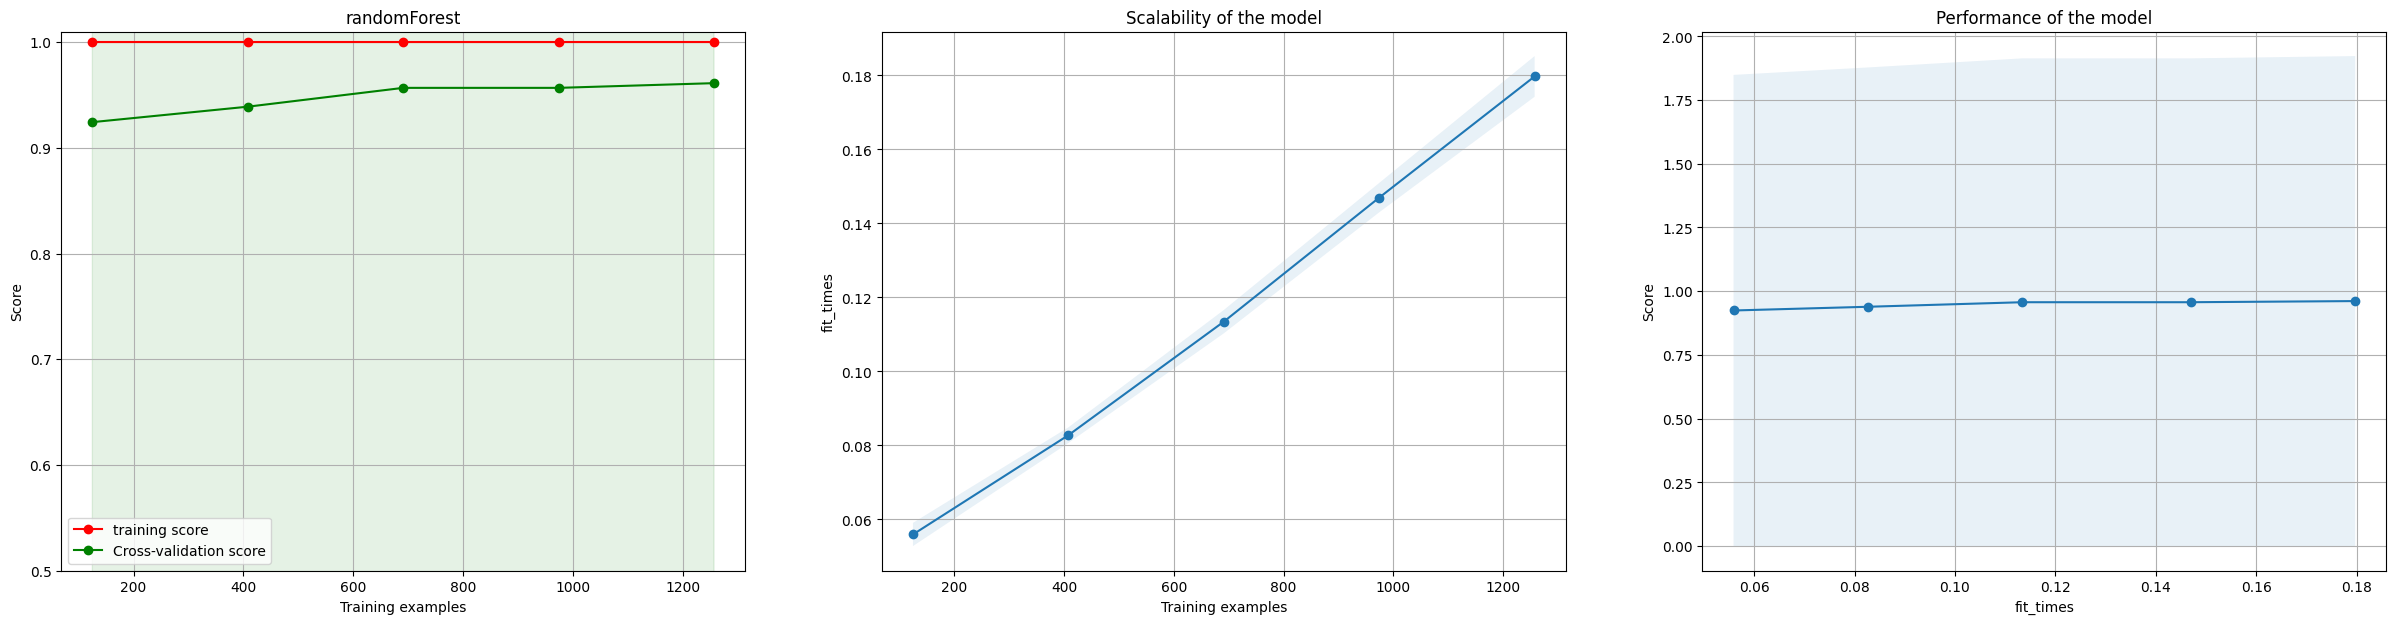

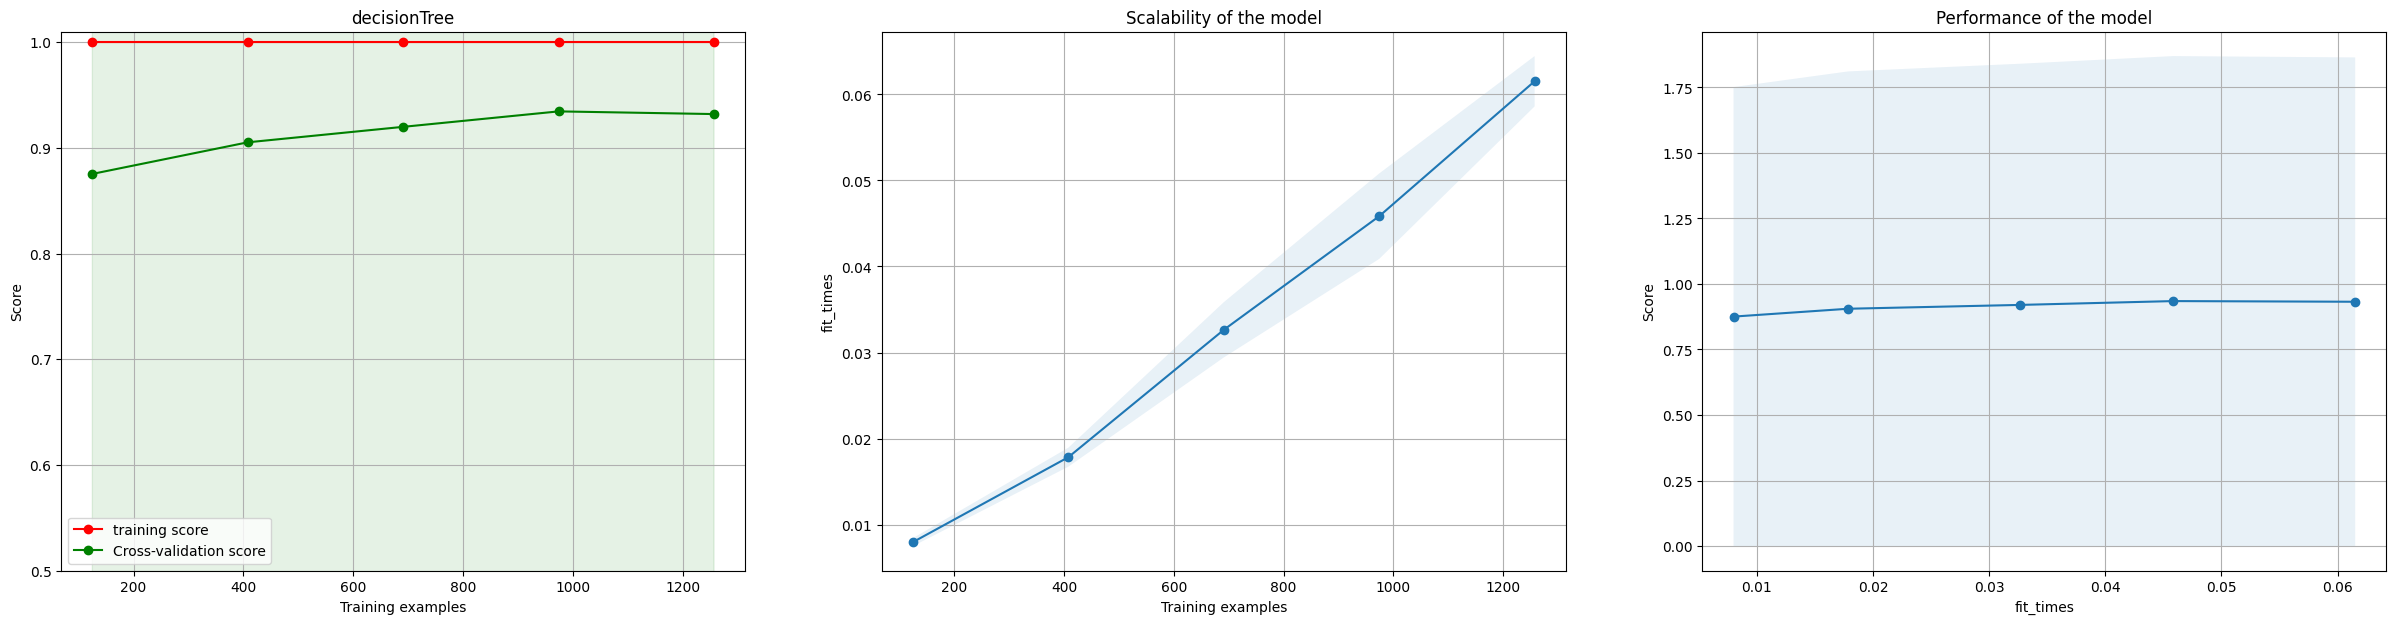

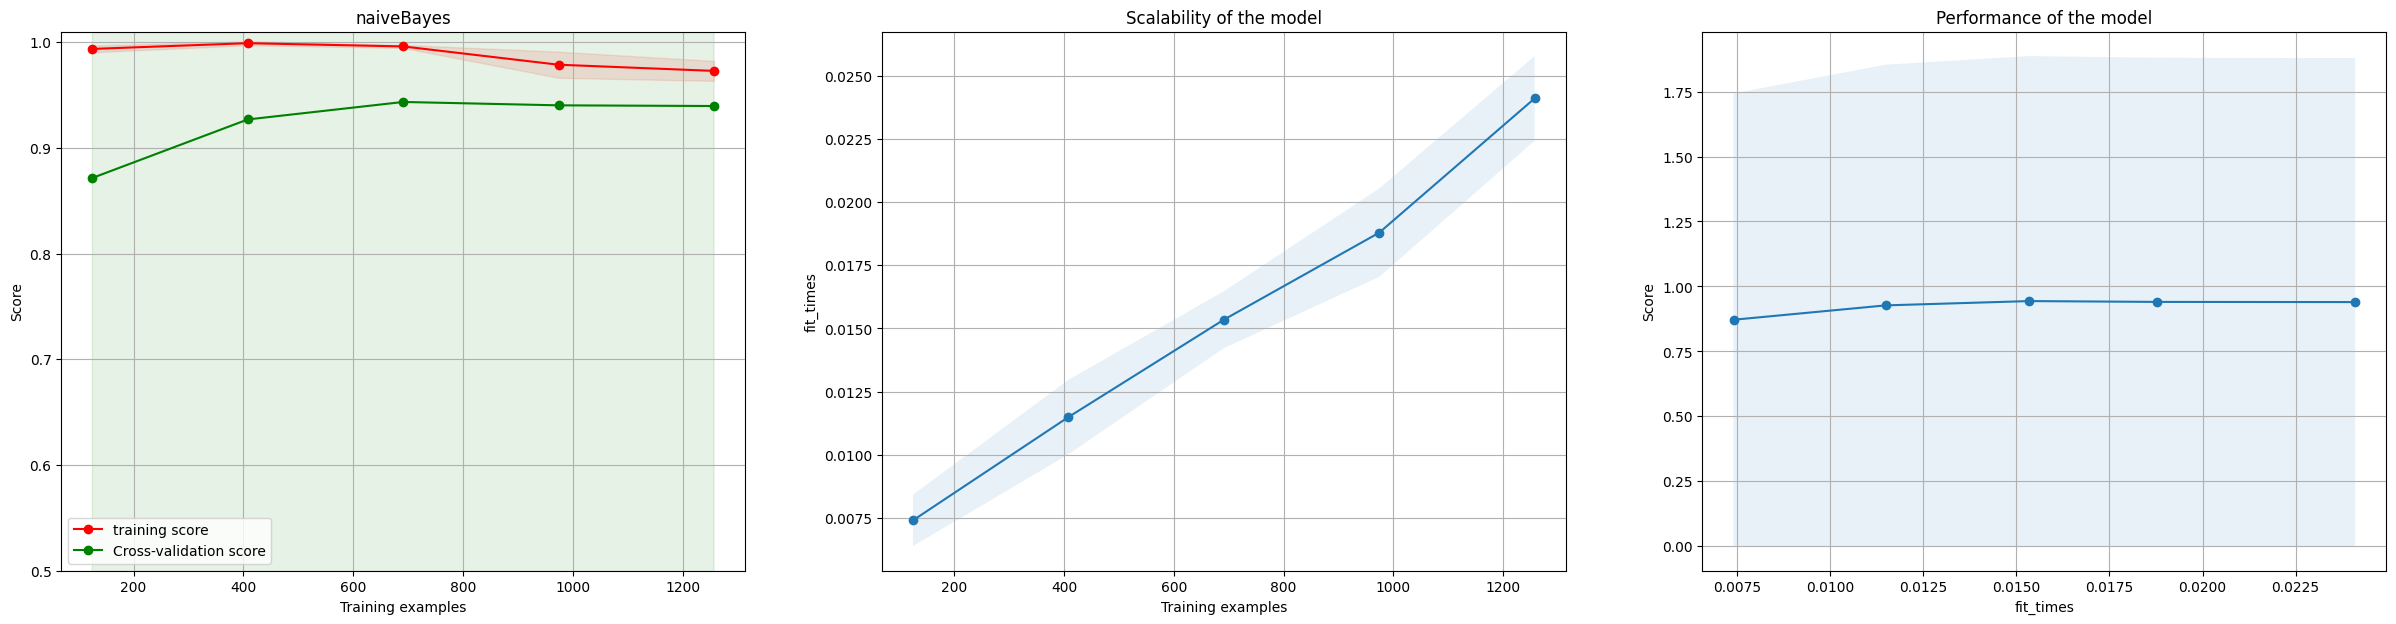

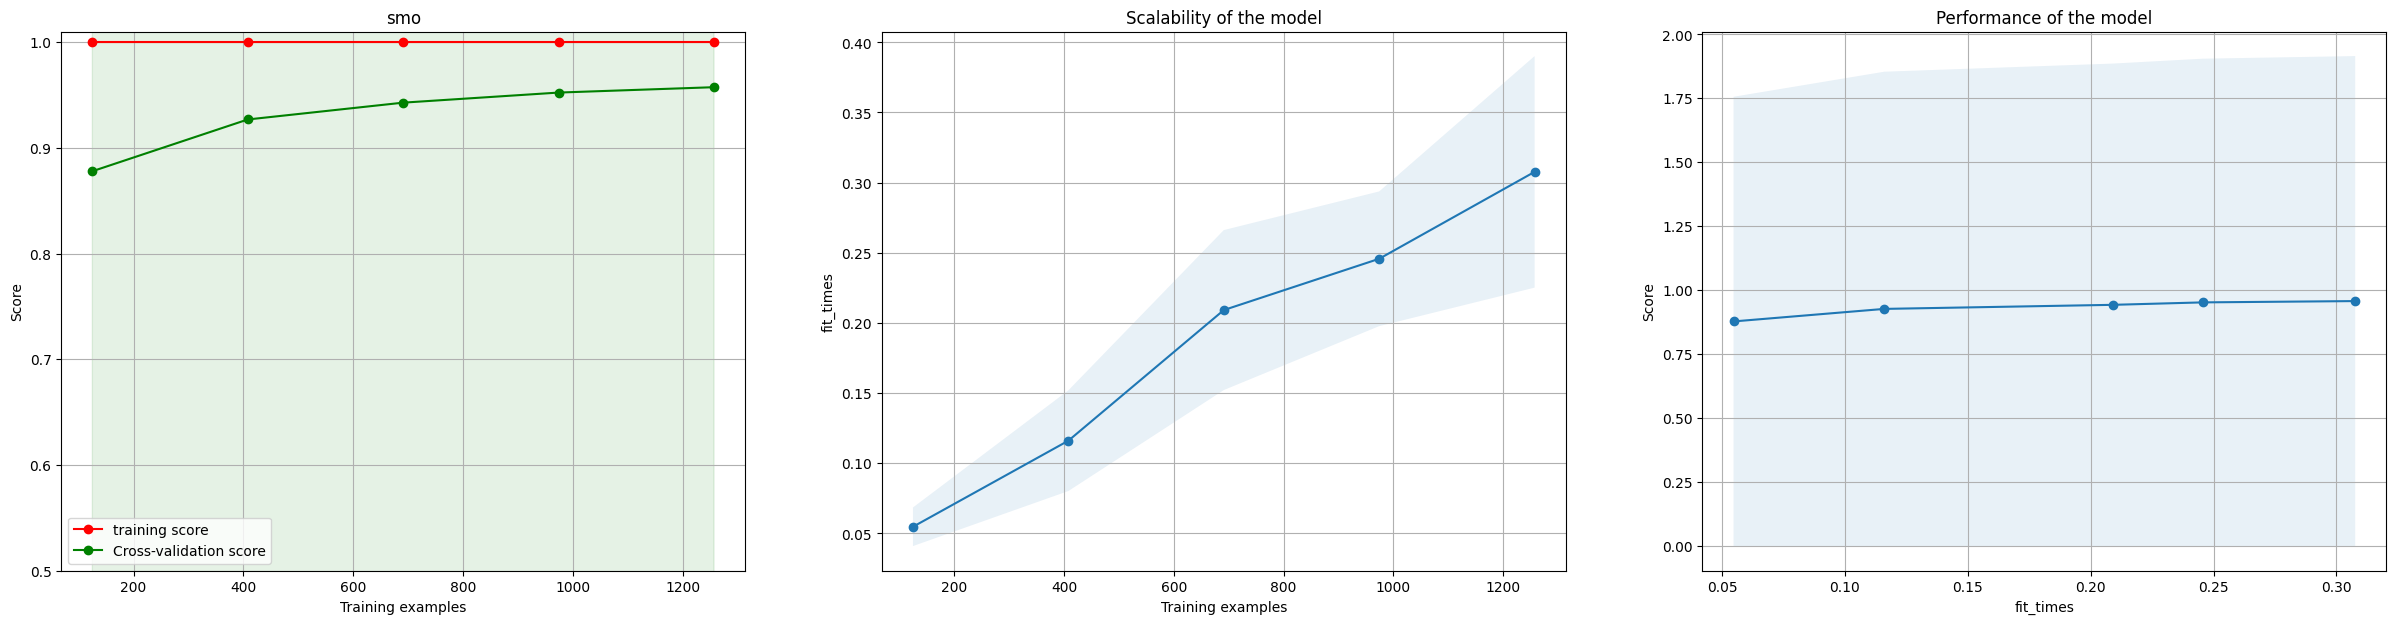

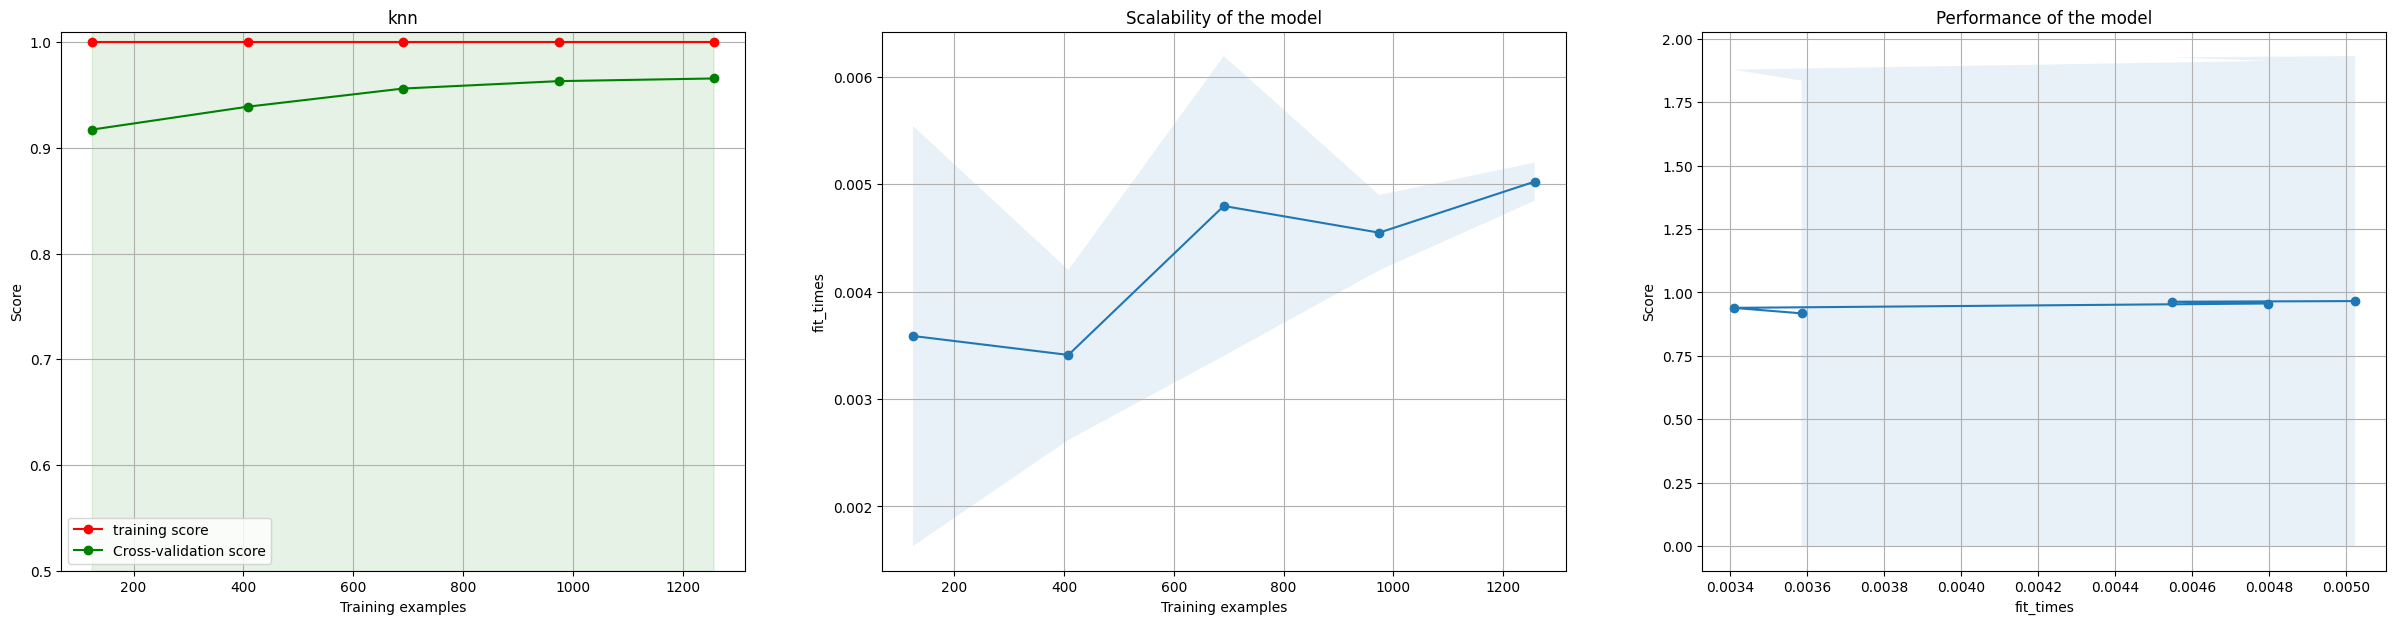

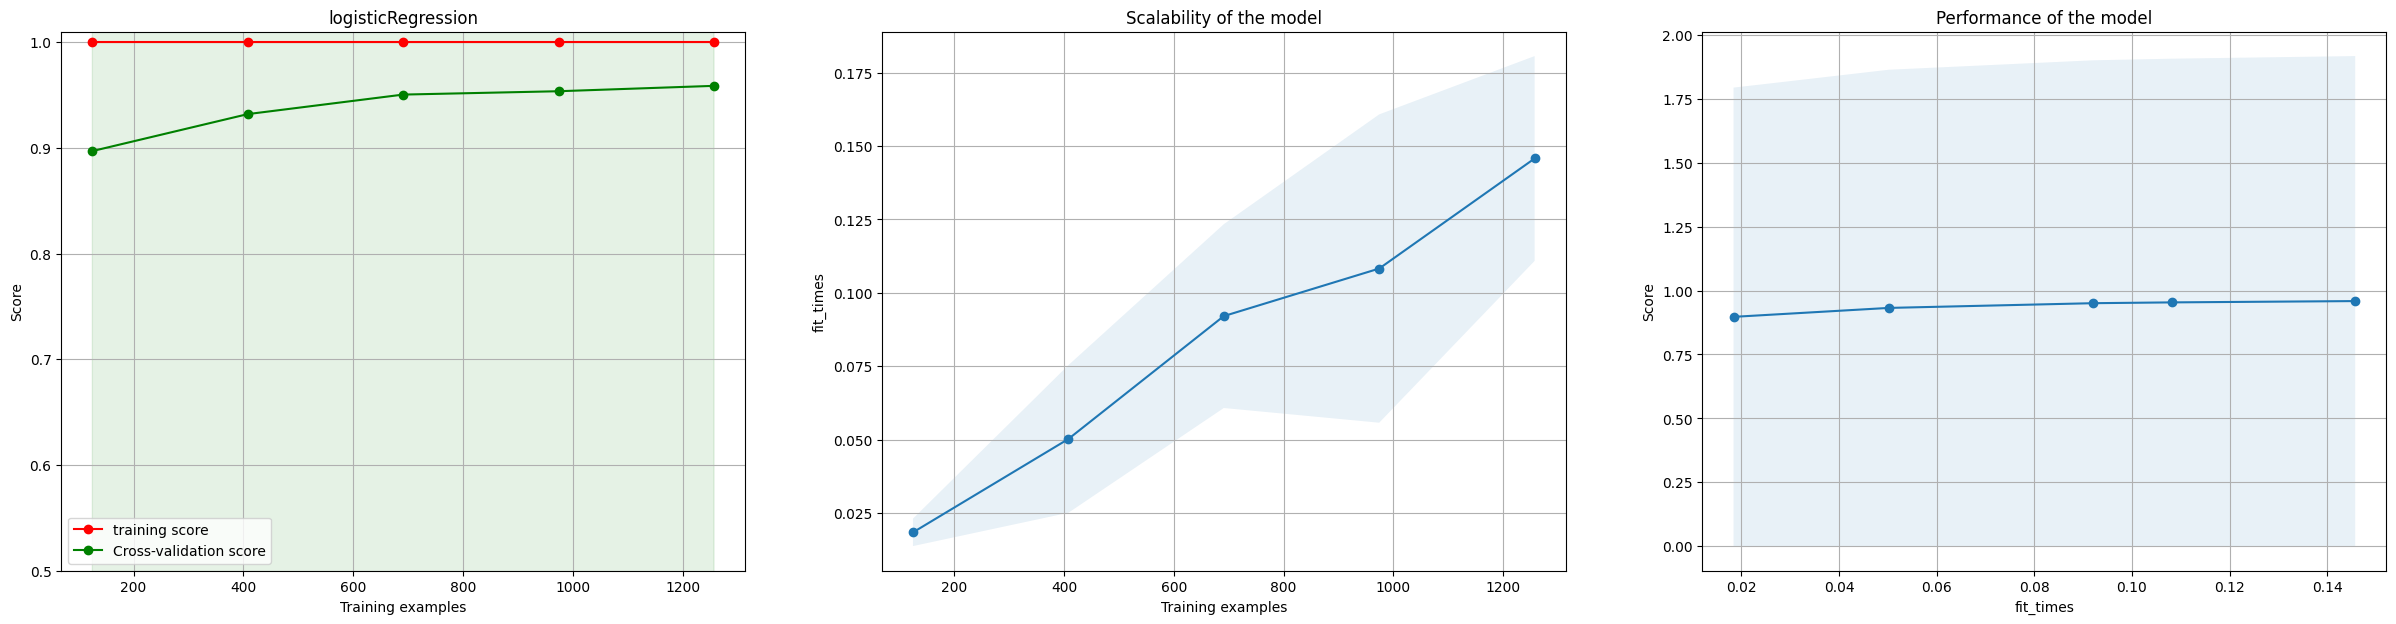

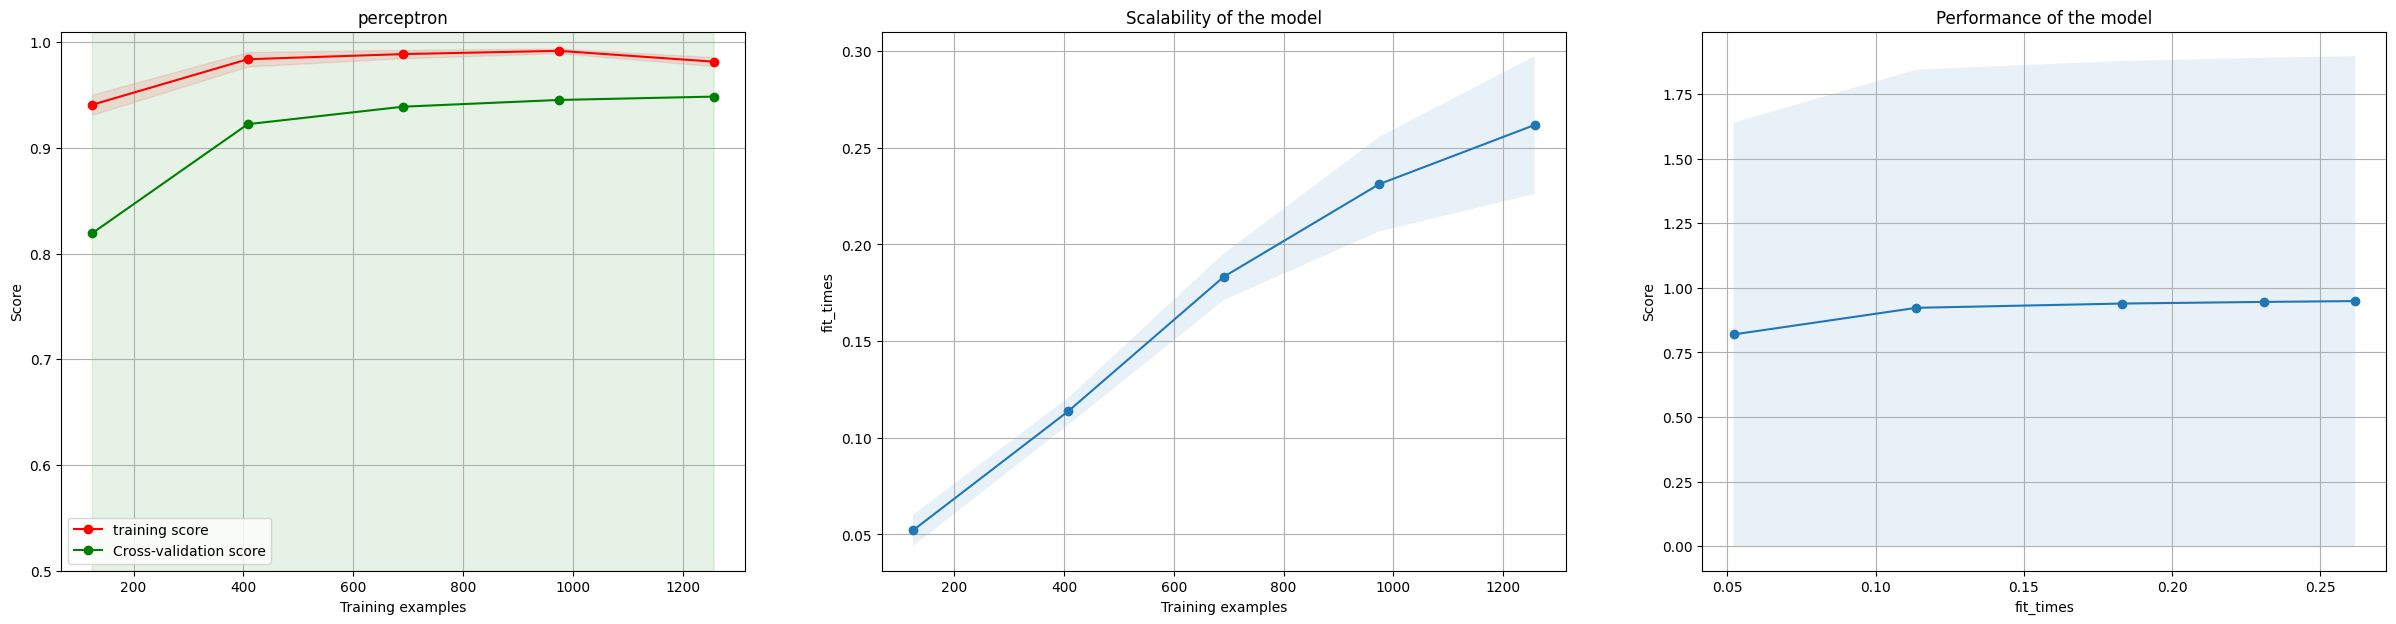

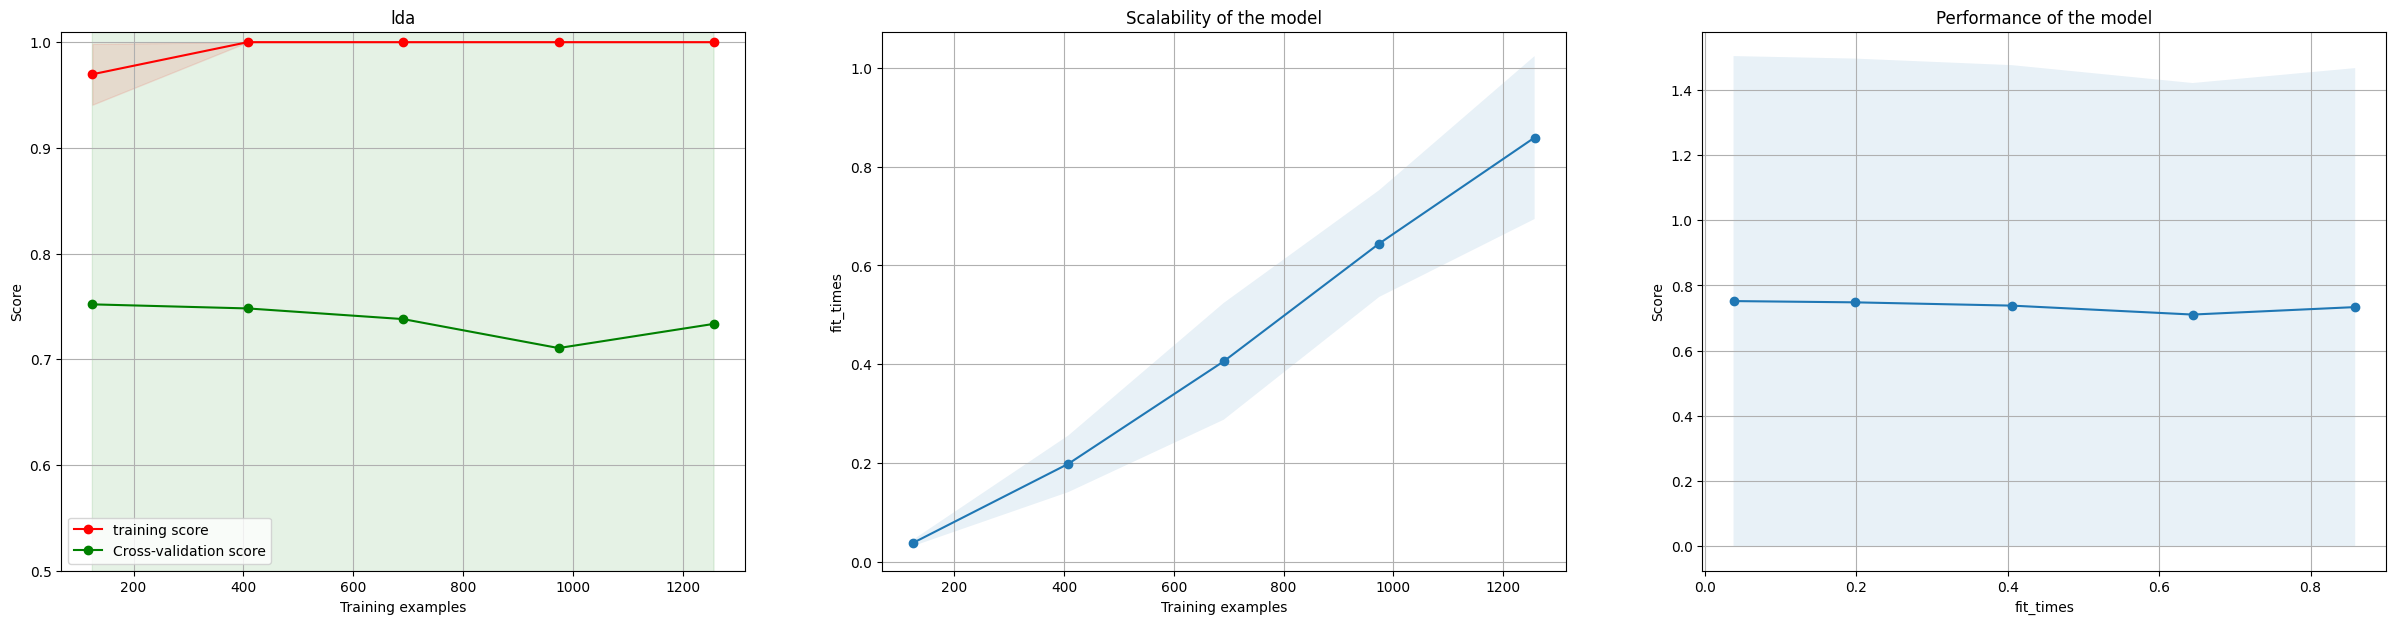

In [17]:
start_time = 0
results, res, classification_report = classify(x_train, x_test, y_train, y_test, classifiers, normalize=['knn'])




In [18]:
importance = feature_importance(x_train, y_train)
print("The top 20 features in Projects are:\n", x_train.columns[np.argsort(-importance)[:20]])

The top 20 features in Projects are:
 Index(['exception', 'throws', 'should', 'io', 'run', 'description', 'close',
       'for', 'assert', 'expect', 'equal', 'thrown', 'resource',
       'representation', 'int', 'connection', 'get', 'error', 'impl', 'check'],
      dtype='object')


In [19]:
print(classification_report)

{'precision': 0.7412587412587412, 'recall': 0.6347305389221557, 'f1-score': 0.6838709677419355, 'support': 167.0}


In [20]:
print(results.confusionMatrix)

0     [[154, 13], [6, 220]]
1     [[151, 16], [8, 218]]
2     [[146, 21], [7, 219]]
3      [[158, 9], [8, 218]]
4      [[160, 7], [4, 222]]
5     [[157, 10], [5, 221]]
6     [[150, 17], [6, 220]]
7    [[106, 61], [37, 189]]
Name: confusionMatrix, dtype: object


In [21]:
results.to_excel('./java_js_results.xlsx', index=False)